## CNN Training (Model Type: `ana-class100`)

Train a CNN network to extract the needle position of an analog dial based on **classification (100 classes: 0.0 .. 9.9)**

### Basic Parameter

IMPORTANT: Do not rename any variables in this section — they are externally referenced in the GitHub action `Train Model`.

* `TFlite_MainType`: Model type name
* `TFlite_Version`: Model version identifier
* `TFlite_Size`: Model architecture defined by size
* `Input_Dir`: Input directory path containing training images
* `Output_Dir`: Output directory path where results (models, logs, etc.) will be saved
* `Input_Shape`: Image dimensions (width, height, channels)

In [1]:
# Model type (No need to adapt)
TFlite_MainType: str = 'ana-class100'

# Define model version (e.g. 0180 -> v1.80)
TFlite_Version: str  = 'xxxx'

# Choose model size
TFlite_Size: str     = 's1'
# Model size pool (Available models: `./src/models/ana_class100.py`)
Available_Model_Sizes = {'s1', 's2'}

# Input folder
# Images will be resized automatically 
# Exception: Using folder name: `data_resize_all`
Input_Dir: str  = 'data_raw_all'

# Output folder
Output_Dir: str = 'models/ana-class100'

# Input image size [width, height, channels]
Input_Shape = (32, 32, 3)


In [2]:
# Parameters
TFlite_Version = 201
TFlite_Size = "s1"
Output_Dir = "models_tmp"


### Load Libraries

In [3]:
import os
import sys
import glob
from pathlib import Path
import random
import math
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import keras

from src.models.ana_class100 import *
from src.utils.augmentation import random_invert_image, random_white_balance

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from src.utils.plot_functions import (plot_loss, plot_dataset_distribution, plot_dataset_analog, 
                                      plot_dataset_analog_result, plot_divergence)
from src.models.evaluation import predict_and_evaluate, get_false_predictions


%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)


# Make sure version is at least 4 characters long if defined with digits only (e.g. papermill paramter 100 -> 0100)
if str(TFlite_Version).isdigit() and len(str(TFlite_Version)) < 4:
    TFlite_Version = str(TFlite_Version).zfill(4)


# Validate model size input
if TFlite_Size not in Available_Model_Sizes:
    raise ValueError(f"Invalid TFlite_Size '{TFlite_Size}'. Must be one of: {', '.join(Available_Model_Sizes)}")


# Prepare folders
if not (Path(Input_Dir).exists() and Path(Input_Dir).is_dir()): # Check if input is availabe
    sys.exit(f"Folder '{Input_Dir}' does not exist.")
    
Path(Output_Dir).mkdir(parents=True, exist_ok=True)  # Create output folder if it doesn't exist


# Disable GPUs
try:
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass


2025-08-30 10:44:22.385375: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-30 10:44:22.388371: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-30 10:44:22.394791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756550662.408533    2364 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756550662.412710    2364 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-30 10:44:22.428622: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

2025-08-30 10:44:25.076060: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Load images

* The images are expected in the "Input_Dir"
* The image size must be 32 x 32 with 3 color channels (RGB)
* The first 3 digits of image filename must contain the real value representation of the image:
  * Generic: `x.y_zzzz.jpg`
  * Example: `4.6_main_ana1_2019-06-02T050011.jpg`

| Filename Part | Description                  | Usage                    |
|---------------|------------------------------|--------------------------|
| x.y           | Represented value (e.g. 4.6) | **Value to be learned**  |
| _zzzz         | Further file description     | Not required / processed |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename
* Split dataset into training and validation parts

In [4]:
files = glob.glob(f"{Input_Dir}/*.jpg")
num_files = len(files)

# Prepare data containers
f_data = np.empty(num_files, dtype="<U250")
x_data = np.empty((num_files, Input_Shape[0], Input_Shape[1], Input_Shape[2]), dtype="float32")
y_data = np.empty(num_files)

# Process files
for i, file in enumerate(files):
    # Read image file
    image_bytes = tf.io.read_file(file)
    image = tf.image.decode_image(image_bytes, channels=Input_Shape[2], expand_animations=False)

    # Resize image (if required)
    if image.shape[0] != Input_Shape[0] or image.shape[1] != Input_Shape[1]:
        image = tf.image.resize(image, [Input_Shape[0], Input_Shape[1]], method=tf.image.ResizeMethod.MITCHELLCUBIC)
        image = tf.clip_by_value(tf.cast(image, tf.float32), 0.0, 255.0)
    else:
        image = tf.cast(image, tf.float32)
    
    # Extract truth value from filename and save as category [0.0 .. 9.9]
    base = Path(file).name
    category = float(base[:3])
    
    # Save data
    f_data[i] = file
    x_data[i] = image.numpy()
    y_data[i] = category

    if i % 500 == 0:
        print(f"{i} files processed...")


print("Data count: ", len(y_data))
print(x_data.shape)
print(np.expand_dims(y_data, axis=1).shape)


0 files processed...


500 files processed...


1000 files processed...


1500 files processed...


Data count:  1838
(1838, 32, 32, 3)
(1838, 1)


### Dataset Distribution

Uneven distribution of data can lead to poorer results.

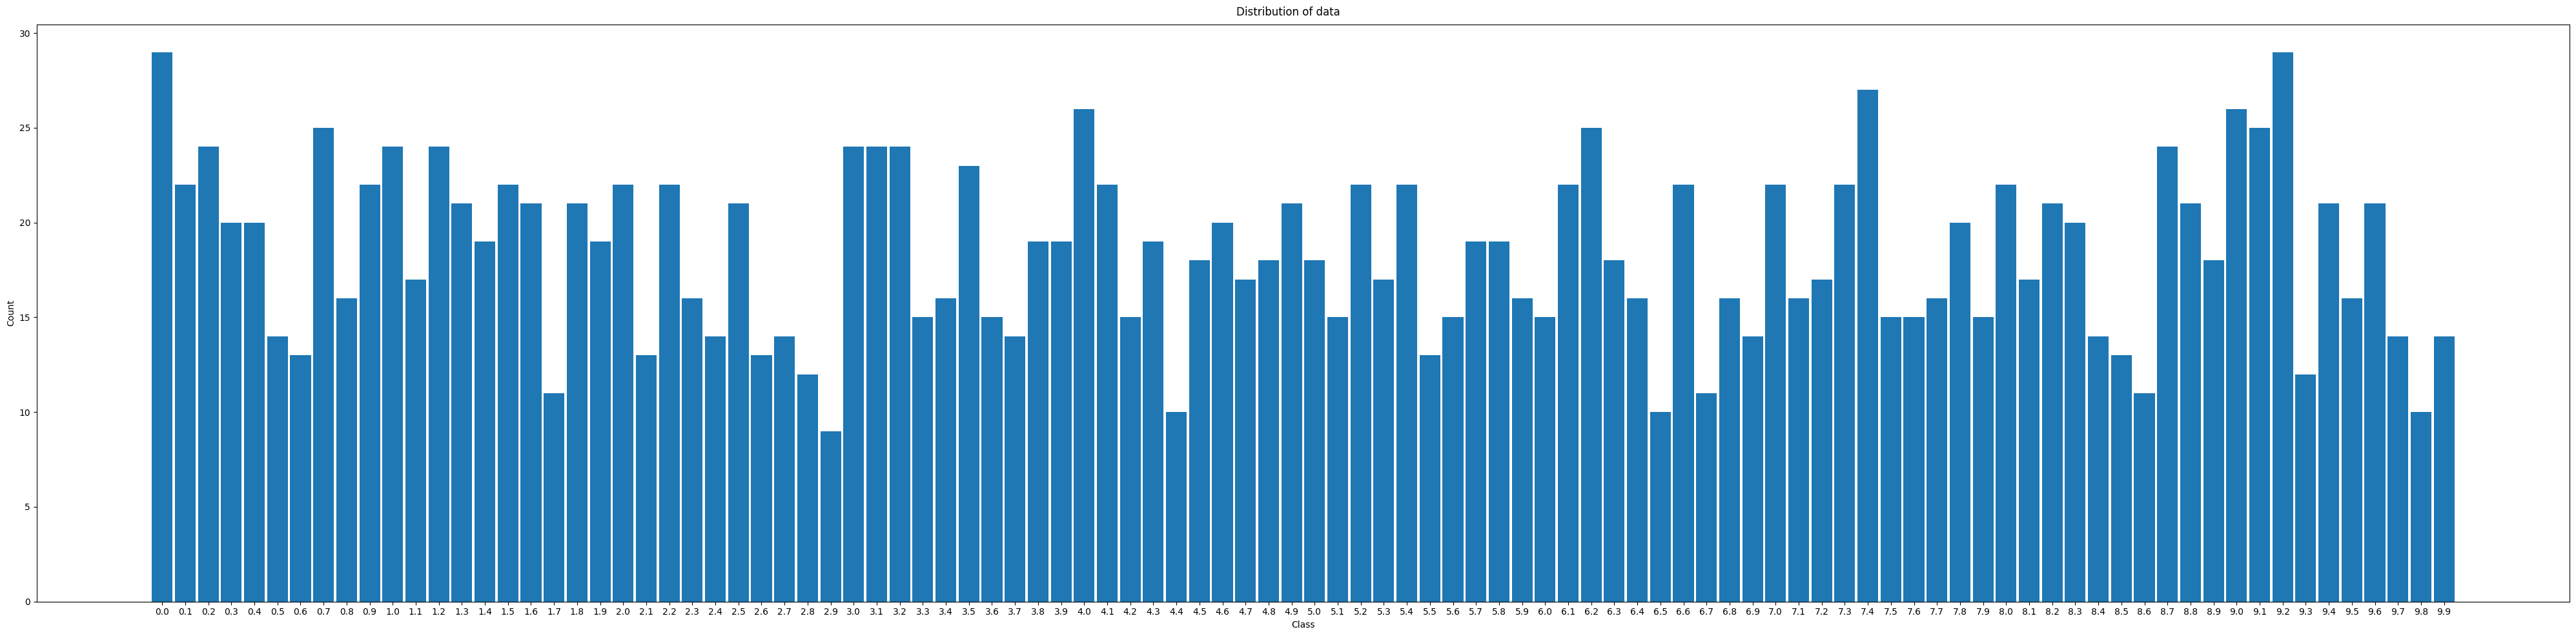

In [5]:
_ = plot_dataset_distribution(y_data)


### Model Definition

The layout of the network ist a typcial CNN network with alternating 2x **Conv2D**, **BatchNormalization** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

**Dropout** between CNN layers are 0.2, between fully connected layers 0.4, but only the fully connected output layer.

* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (100) - classification 0.0 ... 9.9

In [6]:
if (TFlite_Size == "s1"):
    model = model_ana_class100_s1(input_shape=(Input_Shape[0], Input_Shape[1], Input_Shape[2]), learning_rate=5e-4)
elif (TFlite_Size == "s2"):
    model = model_ana_class100_s2(input_shape=(Input_Shape[0], Input_Shape[1], Input_Shape[2]), learning_rate=5e-4)
else:
    raise ValueError(f"TFlite_Size: '{TFlite_Size}' is not supported.")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 2, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             

 Total params: 114,928 (448.94 KB)

 Trainable params: 114,410 (446.91 KB)

 Non-trainable params: 518 (2.02 KB)

### Prepare Datasets / Data Augmentation

Training data


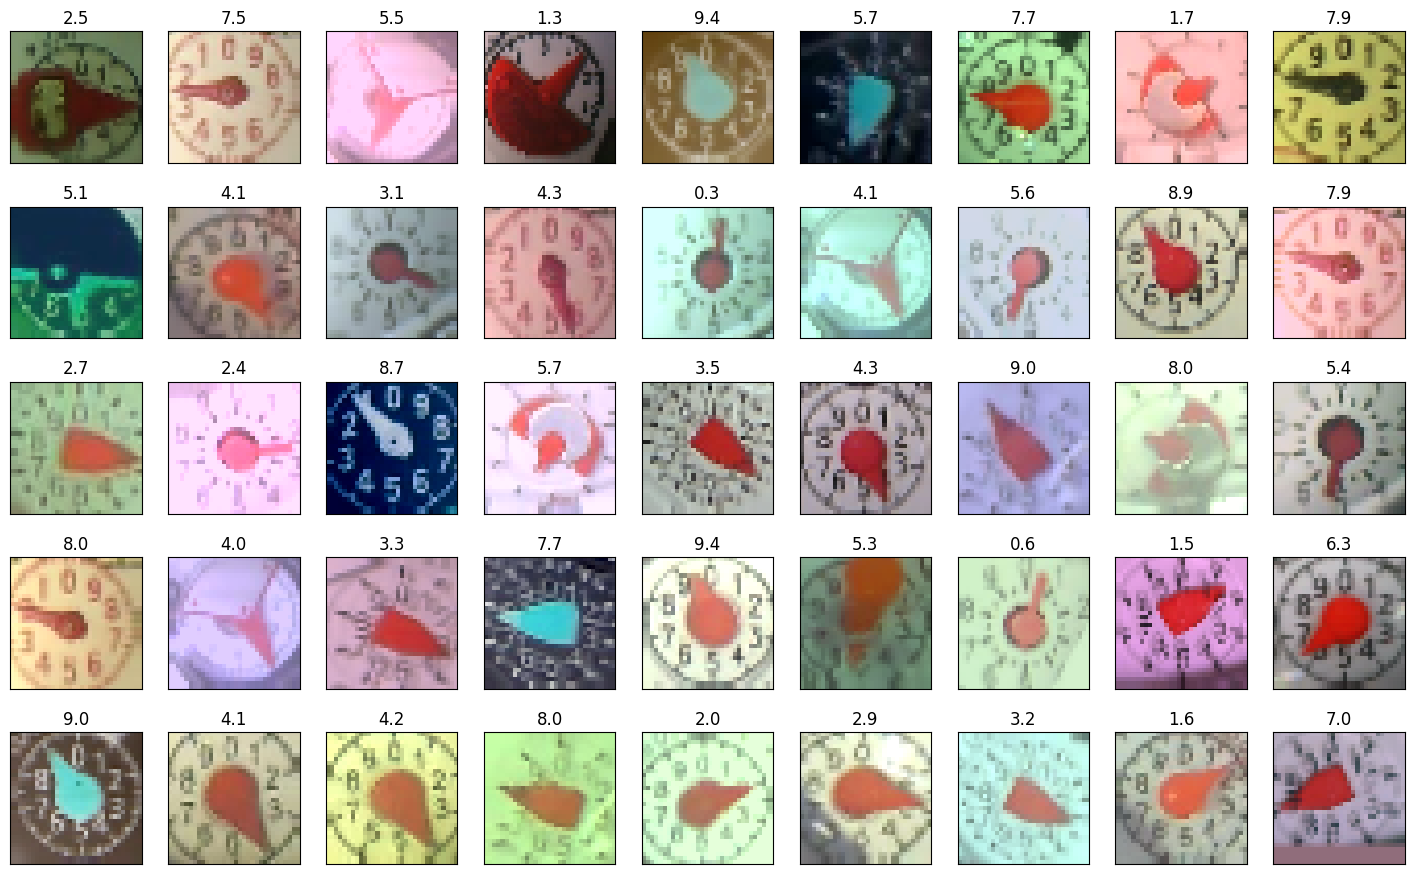

  
Validation data


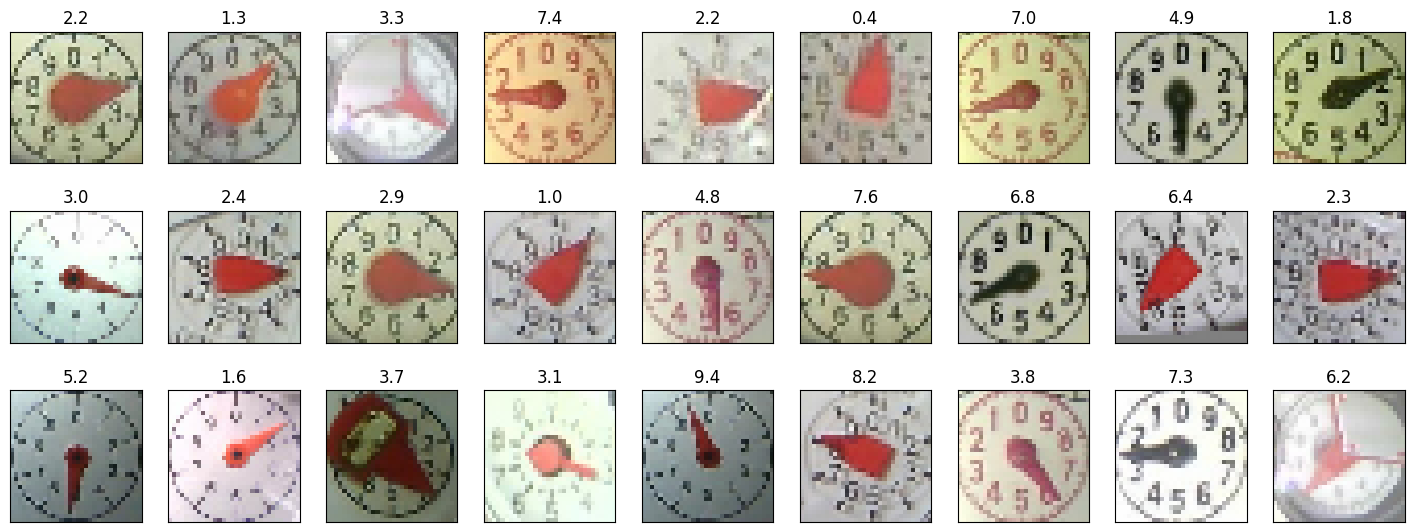

In [7]:
# Parameter
###############################
Validation_Percentage = 0.2 # (0.0 == 0%: Use all images for training, none for validation)
Batch_Size = 8
Shift_Range = 1
Brightness_Range = 0.2
Zoom_Range = 0.05
Channel_Shift_Range = 5
Shear_Range = 1
###############################


# Augmentation helper function
def preprocessing(x):
    x = random_white_balance(x)
    x = random_invert_image(x)
    x = np.clip(x, 0.0, 255.0)
    return x.astype(np.float32)


# Shuffle dataset
x_data, y_data, f_data = shuffle(x_data, y_data, f_data)

# Split data into training and validation dataset
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Validation_Percentage)
y_train = keras.utils.to_categorical(y_train * 10, 100)
y_test = keras.utils.to_categorical(y_test * 10, 100)

# Prepare training dataset (with augmentation)
print("Training data")
datagen = ImageDataGenerator(
    width_shift_range=[-Shift_Range, Shift_Range], 
    height_shift_range=[-Shift_Range, Shift_Range],
    brightness_range=[1 - Brightness_Range, 1 + Brightness_Range],
    zoom_range=[1 - Zoom_Range, 1 + Zoom_Range],
    channel_shift_range=Channel_Shift_Range,
    shear_range=Shear_Range,
    preprocessing_function=preprocessing
)

train_iterator = datagen.flow(x_train, y_train, batch_size=Batch_Size)
plot_dataset_analog(train_iterator)

# Prepare validation dataset (without augmentation)
if (Validation_Percentage > 0):
    datagen_val = ImageDataGenerator() # No augmentation for validation
    validation_iterator = datagen_val.flow(x_test, y_test, batch_size=Batch_Size)
    print("  ")
    print("Validation data")
    plot_dataset_analog(validation_iterator, rows=3)


### Training
 
* Train the model using augmented training data and unaltered validation data
* Visualize training and validation performance over epochs (e.g., loss and accuracy curves)
* Avoid significant overfitting: The validation performance should not deviate heavily from training due to augmentation being applied only to the training data
* Best-performing model automatically selected, not necessarily the final one. The optimal model is often found within the last ~30-40 epochs

/home/runner/work/neural-network-analog-needle-readout/neural-network-analog-needle-readout/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


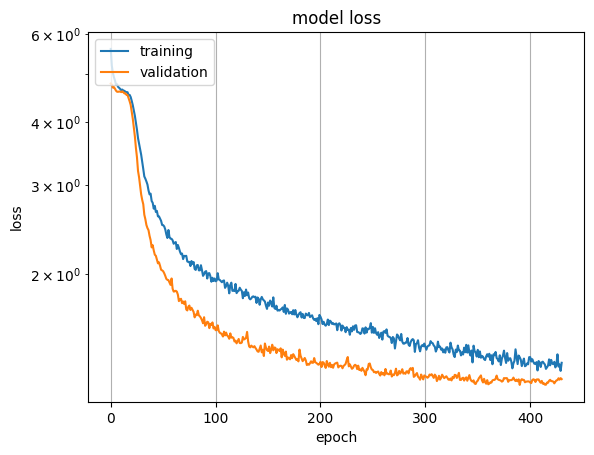

In [8]:
# Parameter
###############################
Training_Epochs = 600
###############################

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=10, min_lr=1e-5, verbose=0
)

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss', mode='min', patience=40, restore_best_weights=True, verbose=0
)

# Train model
if (Validation_Percentage > 0):
    history = model.fit(
        train_iterator, validation_data = validation_iterator, epochs = Training_Epochs, 
        callbacks=[lr_scheduler, early_stopping], verbose=0
    )
else:
    history = model.fit(
        train_iterator, epochs = Training_Epochs, 
        callbacks=[lr_scheduler, early_stopping], verbose=0
    )

# Plot model loss graph
_ = plot_loss(history, validation=Validation_Percentage > 0)


### Model verification

* The following code uses the trained model to check the deviation for each picture (train + validation).
* The accepted_deviation can be used to get the accuracy with allowed differences (for instance +/- 0.1)
* The first (max) 49 false predicted images will be shown
* A csv-file with all false predicted images will be created. It can be used for relabeling with this tool: https://github.com/haverland/collectmeteranalog

In [9]:
# Parameters
###############################
Accepted_Deviation = 0.1
###############################

# Predict and evaluate results
predicted_val, expected_val, deviation_val = predict_and_evaluate(model=model, x_data=x_data, y_data=y_data)

# Process false predictions
false_predictions_result = get_false_predictions(expected_val=expected_val, predicted_val=predicted_val, deviation_val=deviation_val, 
                               x_data=x_data, f_data=f_data, accepted_deviation=Accepted_Deviation)


Accuracy: 97.82 % (Images: 1838 | False Predicted: 40) | Accepted Deviation: 0.1


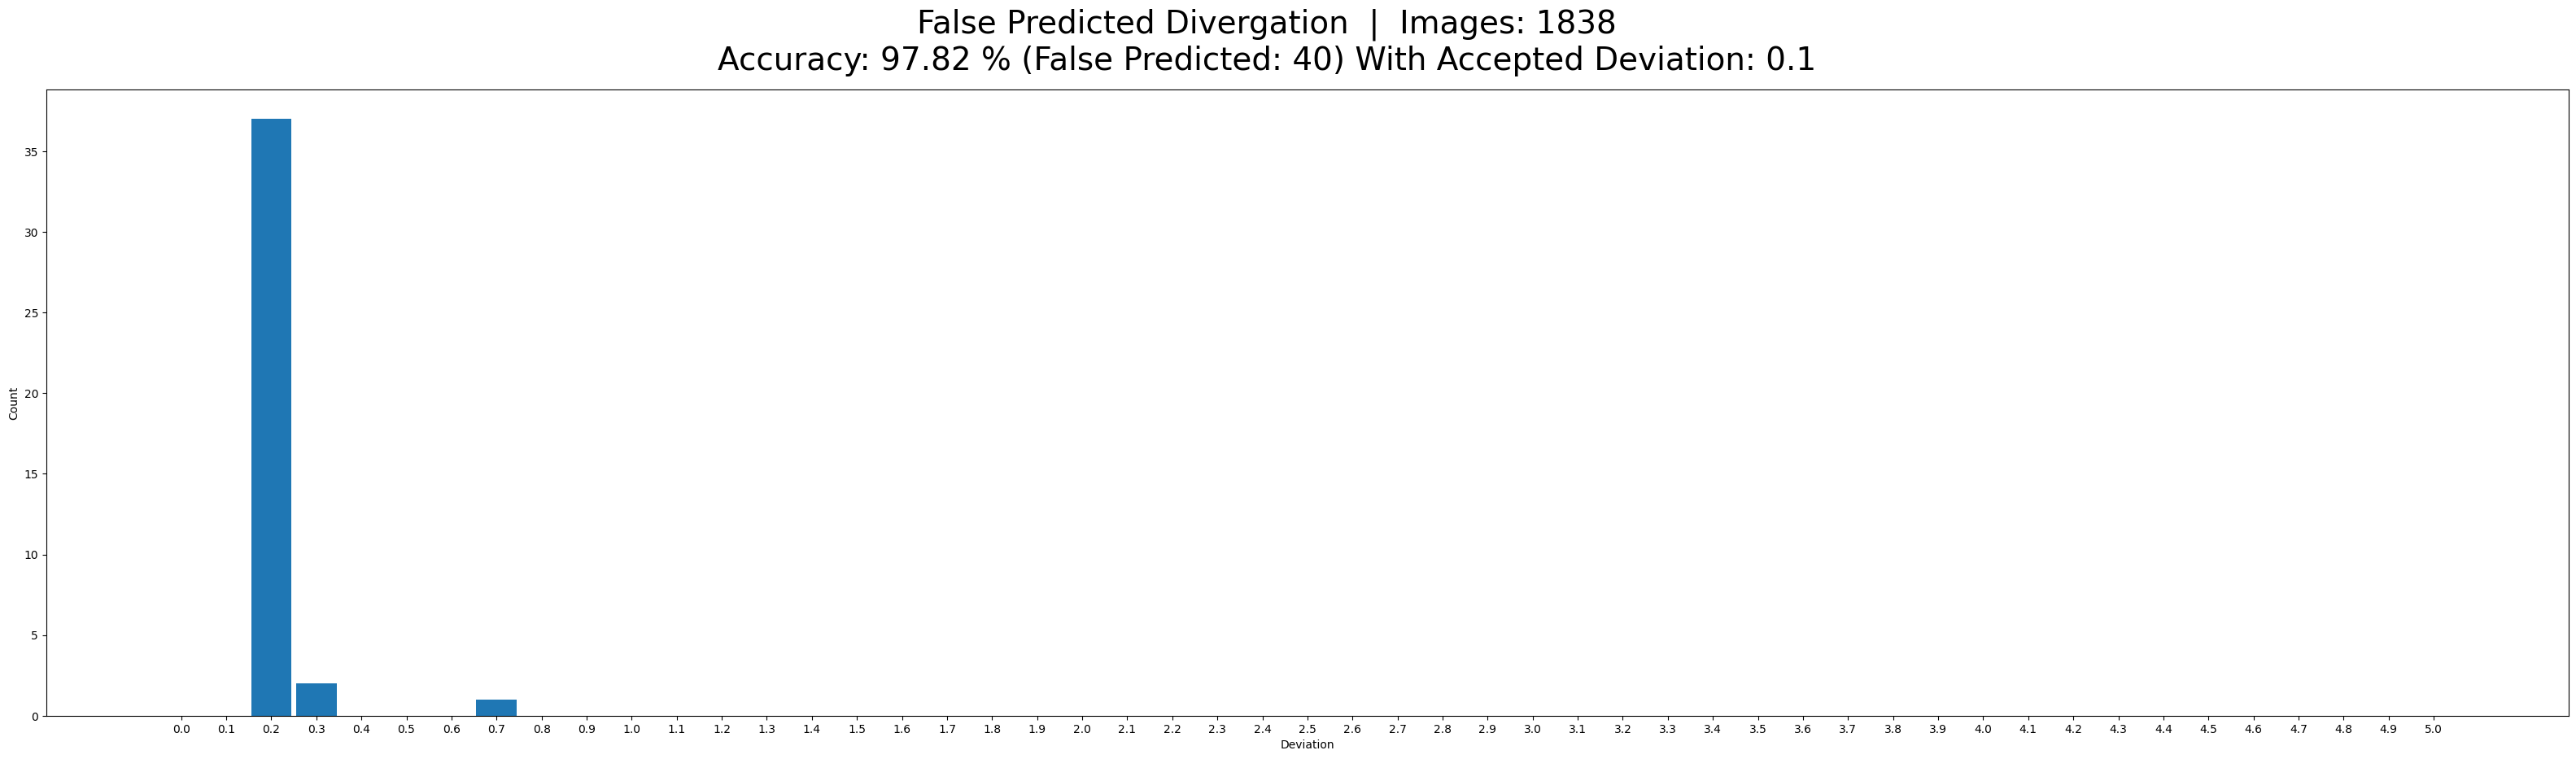

In [10]:
# Plot false predicted divergation
print(f"Accuracy: {(1 - len(false_predictions_result['dev']) / len(y_data)) * 100.0:.2f} % (Images: {len(y_data)} | False Predicted: {len(false_predictions_result['dev'])}) | Accepted Deviation: {Accepted_Deviation}")

title = f"False Predicted Divergation  |  Images: {len(y_data)}\nAccuracy: {(1 - len(false_predictions_result['dev']) / len(y_data)) * 100.0:.2f} % (False Predicted: {len(false_predictions_result['dev'])}) With Accepted Deviation: {Accepted_Deviation}"
_ = plot_divergence(np.bincount(np.array(np.round((np.abs(false_predictions_result['dev']) * 10) % 51).astype(int)), minlength=51), title)


False Predictions (Sorted by highest deviation, max. 49 images)


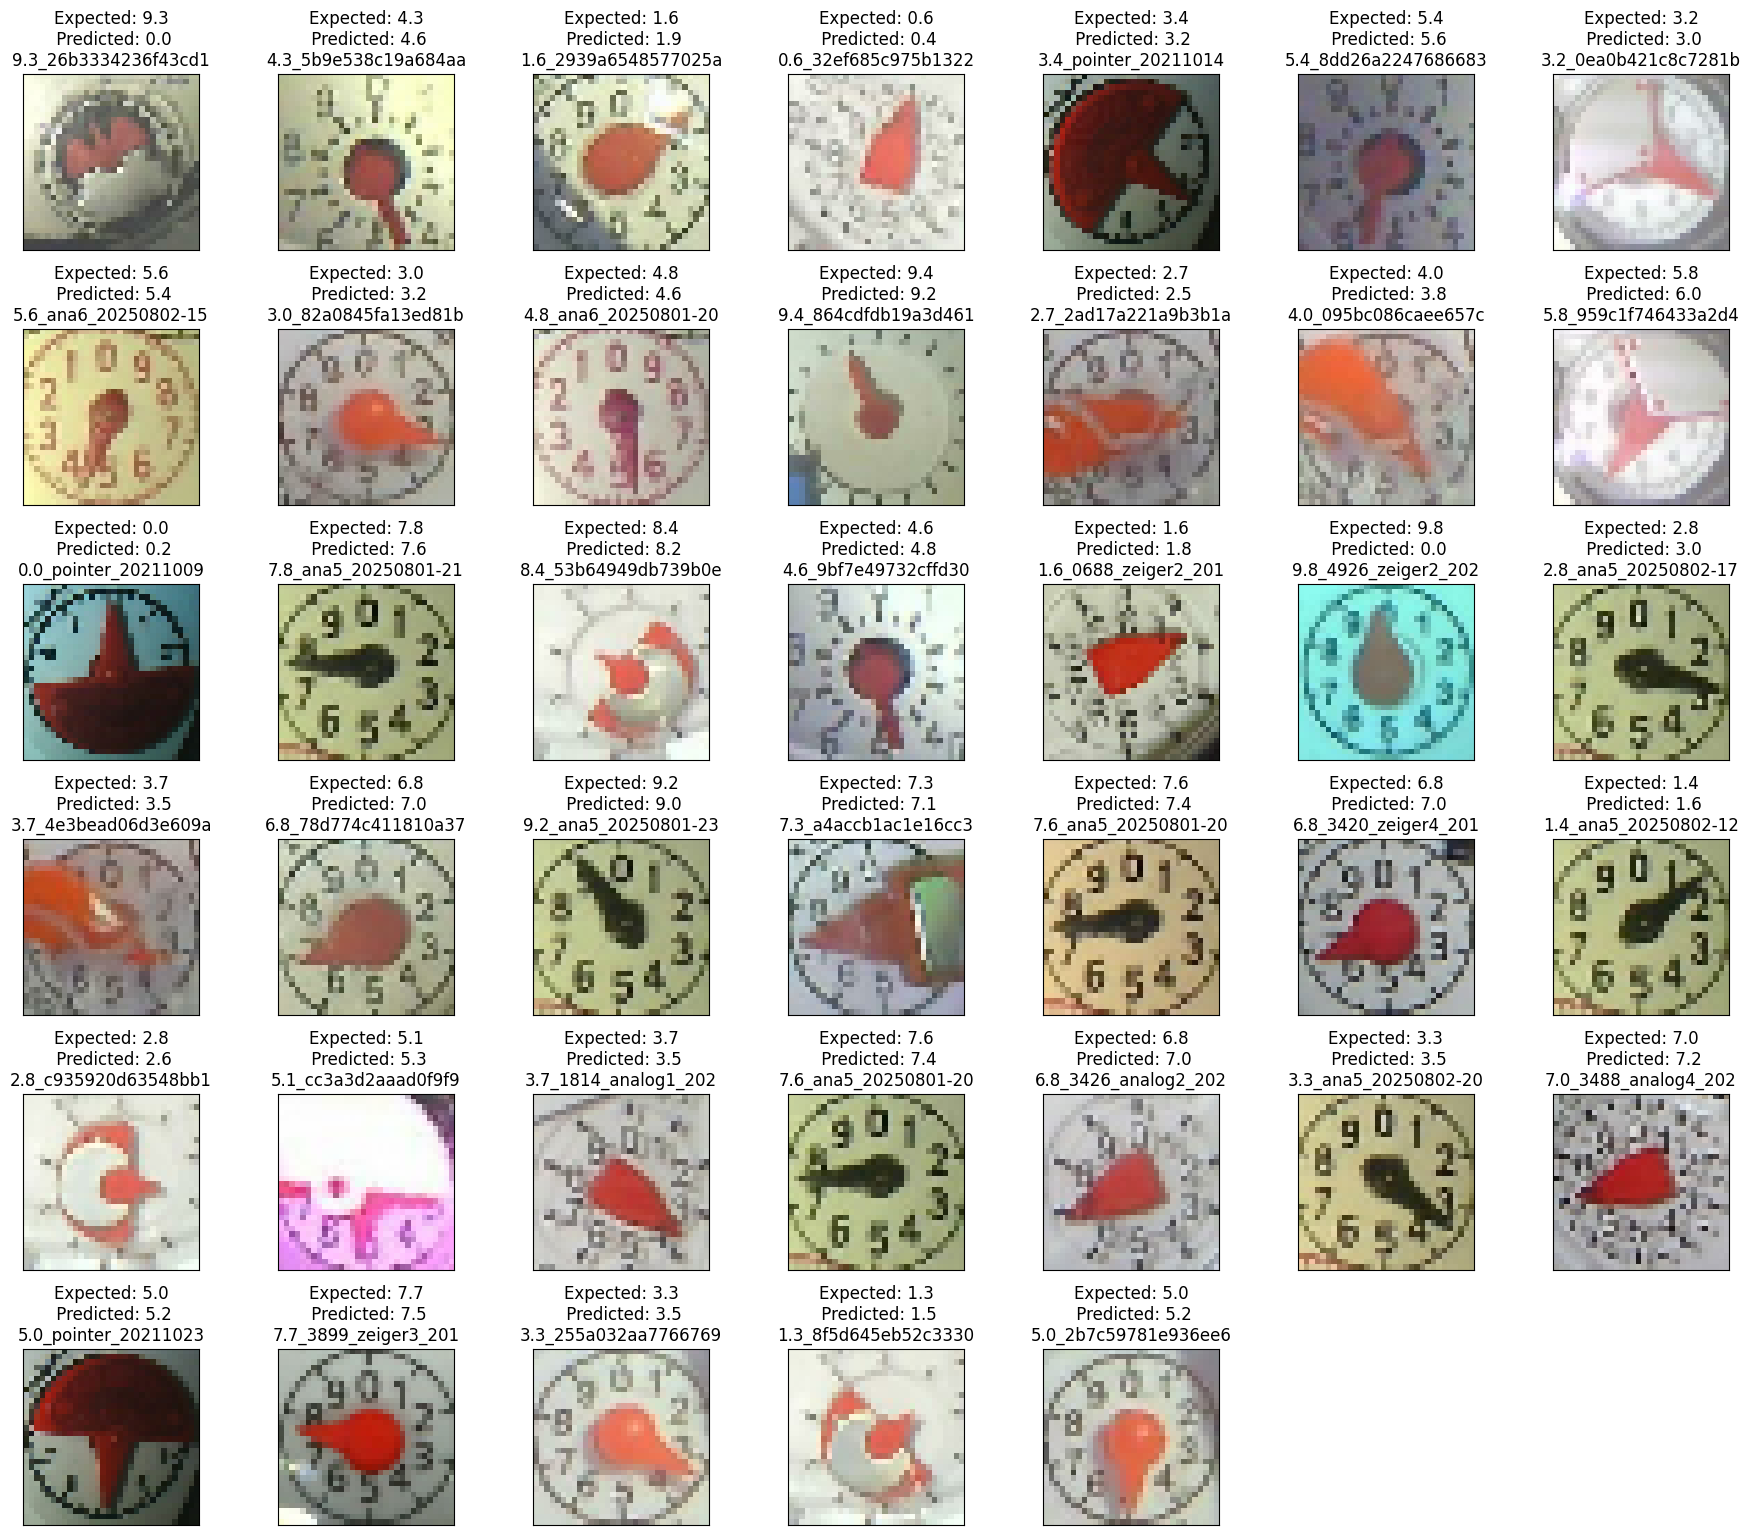

In [11]:
# Plot the dataset of false predictions (Use first 49 entries)
print("False Predictions (Sorted by highest deviation, max. 49 images)")
plot_dataset_analog_result(false_predictions_result["img"], false_predictions_result["lbl"], columns=7, rows=7, figsize=(18,18))


In [12]:
# Save false predicted image list to CSV
# The csv file can be further processed with the tool [collectmeteranalog](https://github.com/haverland/collectmeteranalog) to evaluate or adjust labels

csv_dir = f"{Output_Dir}/training_details/{TFlite_MainType}_{TFlite_Version}_{TFlite_Size}/"
Path(csv_dir).mkdir(parents=True, exist_ok=True)  # Create csv folder if it doesn't exist

false_predicted_df = pd.DataFrame(list(zip(false_predictions_result["file"], false_predictions_result["pred"], false_predictions_result["exp"], 
                                  false_predictions_result["dev"])), columns=["File", "Predicted", "Expected", "Deviation"])
false_predicted_df.to_csv(f"{csv_dir}/{TFlite_MainType}_{TFlite_Version}_{TFlite_Size}_false_predicted.csv", index=True, index_label="Index")


###############################################################################################################################################################################
# Save false predicted image list to CSV (--> LEGACY File Syntax)
# The csv file can be further processed with the tool [collectmeteranalog](https://github.com/haverland/collectmeteranalog) to evaluate or adjust labels

#false_predicted_df = pd.DataFrame(false_predicted_files)
#false_predicted_df.to_csv(f"{csv_dir}/{TFlite_MainType}_{TFlite_Version}_{TFlite_Size}_false_predicted.csv", index=True)


### Save the model

* Save the model to the file with the "tflite" file format
* quantize the model and store it as _q.tflite

In [13]:
FileName = f"{Output_Dir}/{TFlite_MainType}_{TFlite_Version}_{TFlite_Size}.tflite"

# TensorFlow Lite conversion
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model
with open(FileName, "wb") as f:
    f.write(tflite_model)

print(f"Model saved successfully. File: {FileName}")
print(f"File size: {Path(FileName).stat().st_size} bytes")


INFO:tensorflow:Assets written to: /tmp/tmptgdonjjl/assets


INFO:tensorflow:Assets written to: /tmp/tmptgdonjjl/assets


Saved artifact at '/tmp/tmptgdonjjl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 100), dtype=tf.float32, name=None)
Captures:
  140004123461584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004123462160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004123460624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004123460240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004123460432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004123459664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004123463504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004123462736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004123462352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004123463888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14000412346292

Model saved successfully. File: models_tmp/ana-class100_0201_s1.tflite
File size: 466076 bytes


W0000 00:00:1756551881.240636    2364 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1756551881.240662    2364 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-08-30 11:04:41.240925: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmptgdonjjl
2025-08-30 11:04:41.242639: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-08-30 11:04:41.242654: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmptgdonjjl
I0000 00:00:1756551881.257822    2364 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-08-30 11:04:41.260798: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-08-30 11:04:41.346018: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmptgdonjjl
2025-08-30 11:04:41.369381: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

In [14]:
FileName = f"{Output_Dir}/{TFlite_MainType}_{TFlite_Version}_{TFlite_Size}_q.tflite"

# Representative dataset function
def representative_dataset():
    for n in range(x_data.shape[0]):
        data = np.expand_dims(x_data[n], axis=0)
        yield [data.astype(np.float32)]


# TensorFlow Lite conversion with optimizations
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter._experimental_disable_per_channel_quantization_for_dense_layers = True

tflite_quant_model = converter.convert()

# Save the converted model to the specified file
with open(FileName, "wb") as f:
    f.write(tflite_quant_model)

print(f"Model saved successfully. File: {FileName}")
print(f"File size: {Path(FileName).stat().st_size} bytes")


INFO:tensorflow:Assets written to: /tmp/tmpsiy50d8m/assets


INFO:tensorflow:Assets written to: /tmp/tmpsiy50d8m/assets


Saved artifact at '/tmp/tmpsiy50d8m'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 100), dtype=tf.float32, name=None)
Captures:
  140004123461584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004123462160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004123460624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004123460240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004123460432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004123459664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004123463504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004123462736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004123462352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004123463888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14000412346292

/home/runner/work/neural-network-analog-needle-readout/neural-network-analog-needle-readout/.venv/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


W0000 00:00:1756551882.352657    2364 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1756551882.352677    2364 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


2025-08-30 11:04:42.352826: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpsiy50d8m
2025-08-30 11:04:42.354549: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-08-30 11:04:42.354564: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpsiy50d8m
2025-08-30 11:04:42.372943: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-08-30 11:04:42.456645: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpsiy50d8m
2025-08-30 11:04:42.479783: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 126959 microseconds.


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


Model saved successfully. File: models_tmp/ana-class100_0201_s1_q.tflite
File size: 133504 bytes
